In [1]:
# This notebook analyzes cookies from crawl NL
# (Run with Python 3.6.1 |Anaconda 4.4.0 )

# Th# This notebook analyzes cookies from crawl NL
# (Run with Python 3.6.1 |Anaconda 4.4.0 )

# The crawl includes 4 vantage points and top 30 websites from NL,BG,DE,US, and 61 from US (no DNT).
# The aim is to understanding cookie-variations well enough to design a good country-cookie-metric.
# (E.g., one site, cookie variations for site based on vantage, and between sites, top-3rd parties, ...)
# (Later, this metric will be linked with site and country characteristics in a regression model.)

%pylab inline --no-import-all 
import pandas as pd
import sqlite3
from numpy import nan
from time import time
from glob import glob
from datetime import datetime
import numpy as np
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from tldextract import extract as tldextract  # pip install tldextract
DPI = 120  # used for graphs. check at: http://www.infobyip.com/detectmonitordpi.php

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Two functions that Hadi had to extract domains 

#Function to remove the http, https of site_url
def strip_site(site):
    """Removes leading http:// or https:// and trailing '/'"""
    site = site.lower()
    if site.startswith('http'):
        site = site.replace('https://', '').replace('http://', '')
    if site.endswith('/'):
        site = site[:-1]
    return site

#Function to strip and extract the domains of site_url
def extract_domain(site):
    """Returns domain+tld from a full domain"""
    site = strip_site(site)  # just to be sure
    ext = tldextract(site)
    ret = ".".join([ss for ss in ext[-2:] if ss])
    # In case of gov.ie, or IPs, our 'ret' works better than 'ext.registered_domain'
    return ret

#Function to extract the domains of host
def extract_host(host):
    """Returns domain+tld from a full domain"""
    ext = tldextract(host)
    ret = ".".join([ss for ss in ext[-2:] if ss])
    return ret

#Function to extract the TLD of the websites
def extract_tld(site):
    """Returns domain+tld from a full domain"""
    site = strip_site(site)  # just to be sure
    ext = tldextract(site)
    ret = ".".join([ss for ss in ext[-1:] if ss])
    return ret



### SUCCESS OF THE CRAWL PER VANTAGE POINT

In [3]:
#Read successful crawls

#Connection to the SQLite Database US to create US_S(United States Success) data frame
con = sqlite3.connect('C:\\Users\\elsar_000\\Desktop\\Thesis\\NewData\\crawl.20180313.2344\\from-US\\crawl-data.sqlite')
#Query to get all websites and bool_success and add them in a dataframe 
US_S=pd.read_sql_query("""SELECT site_url, bool_success 
                    FROM site_visits s 
                    LEFT JOIN CrawlHistory h ON
s.site_url=replace(replace(h.arguments, '[http://]http://', ''), '[https://]https://', '') AND command='GET'                     
""", con)
    
print('crawled US sites',(US_S.site_url.count()))
success=US_S[US_S.bool_success==1].count()['bool_success']
print('success US', success)

#Connection to the SQLite Database NL and doing the query to create NL_S(Netherland Success) data frame
con = sqlite3.connect('C:\\Users\\elsar_000\\Desktop\\Thesis\\NewData\\crawl.20180313.2344\\from-NL\\crawl-data.sqlite')
#Query to get all websites and bool_success and add them in a dataframe 
NL_S=pd.read_sql_query("""SELECT site_url, bool_success 
                    FROM site_visits s 
                    LEFT JOIN CrawlHistory h ON
s.site_url=replace(replace(h.arguments, '[http://]http://', ''), '[https://]https://', '') AND command='GET'                     
""", con)
    
print('crawled NL sites',(NL_S.site_url.count()))
success=NL_S[NL_S.bool_success==1].count()['bool_success']
print('success NL', success)

#Connection to the SQLite Database DE and doing the query to create DE_S (Germany success) data frame
con = sqlite3.connect('C:\\Users\\elsar_000\\Desktop\\Thesis\\NewData\\crawl.20180313.2344\\from-DE\\crawl-data.sqlite')
#Query to get all websites and bool_success and add them in a dataframe 
DE_S=pd.read_sql_query("""SELECT site_url, bool_success 
                    FROM site_visits s 
                    LEFT JOIN CrawlHistory h ON
s.site_url=replace(replace(h.arguments, '[http://]http://', ''), '[https://]https://', '') AND command='GET'                     
""", con)

print('crawled DE sites',(DE_S.site_url.count()))
success=DE_S[DE_S.bool_success==1].count()['bool_success']
print('success DE', success)


#Connection to the SQLite Database GB and doing the query to create BG_S (Bulgaria success) data frame
con = sqlite3.connect('C:\\Users\\elsar_000\\Desktop\\Thesis\\NewData\\crawl.20180313.2344\\from-GB\\crawl-data.sqlite')
#Query to get all websites and bool_success and add them in a dataframe 
BG_S=pd.read_sql_query("""SELECT site_url, bool_success 
                    FROM site_visits s 
                    LEFT JOIN CrawlHistory h ON
s.site_url=replace(replace(h.arguments, '[http://]http://', ''), '[https://]https://', '') AND command='GET'                     
""", con)
    
print('crawled BG sites',(BG_S.site_url.count()))
success=BG_S[BG_S.bool_success==1].count()['bool_success']
print('success BG', success)




crawled US sites 181
success US 131
crawled NL sites 181
success NL 138
crawled DE sites 181
success DE 132
crawled BG sites 181
success BG 136


### LOADING THE MEASUREMENT DATA/COOKIES 
A data frame per vantage point is created

In [4]:
# Load the measurement data / cookies - VP:US
#Connect to SQLite Database
con = sqlite3.connect('C:\\Users\\elsar_000\\Desktop\\Thesis\\NewData\\crawl.20180313.2344\\from-US\\crawl-data.sqlite')
#Query to get all cookies and add them in a dataframe
US=pd.read_sql_query("""SELECT site_url, host, name, value, is_session, change, expiry, creationTime
                          FROM site_visits s LEFT JOIN javascript_cookies c 
                          ON s.visit_id=c.visit_id ORDER BY s.visit_id""", con)
US['VP']='US'
US.head()
#US.shape

,site_url,host,name,value,is_session,change,expiry,creationTime,VP
0,http://geoip.hidemyass.com,.hidemyass.com,_gat_UA-950416-58,1,0.0,added,2018-03-14 01:58:20,2018-03-14 01:57:20,US
1,http://geoip.hidemyass.com,.hidemyass.com,_gid,GA1.2.930280486.1520992640,0.0,added,2018-03-15 01:57:20,2018-03-14 01:57:20,US
2,http://geoip.hidemyass.com,.hidemyass.com,_ga,GA1.2.1293913234.1520992640,0.0,added,2020-03-13 01:57:20,2018-03-14 01:57:20,US
3,http://geoip.hidemyass.com,www.hidemyass.com,hidemyassComLocale,en-us,0.0,added,2038-12-31 23:59:59,2018-03-14 01:57:20,US
4,http://geoip.hidemyass.com,.doubleclick.net,test_cookie,CheckForPermission,0.0,added,2018-03-14 02:12:21,2018-03-14 01:57:21,US


In [5]:
# Load the measurement data / cookies - VP:NL
#Connect to SQLite Database
con = sqlite3.connect('C:\\Users\\elsar_000\\Desktop\\Thesis\\NewData\\crawl.20180313.2344\\from-NL\\crawl-data.sqlite')
#Query to get all cookies and add them in a dataframe
NL=pd.read_sql_query("""SELECT site_url, host, name, value, is_session, change, expiry, creationTime
                          FROM site_visits s LEFT JOIN javascript_cookies c 
                          ON s.visit_id=c.visit_id ORDER BY s.visit_id""", con)
NL['VP']='NL'
NL.head()
#NL.shape

,site_url,host,name,value,is_session,change,expiry,creationTime,VP
0,http://geoip.hidemyass.com,.hidemyass.com,_gat_UA-950416-58,1,0.0,added,2018-03-14 00:32:50,2018-03-14 00:31:50,NL
1,http://geoip.hidemyass.com,.doubleclick.net,test_cookie,CheckForPermission,0.0,added,2018-03-14 00:46:50,2018-03-14 00:31:50,NL
2,http://geoip.hidemyass.com,.hidemyass.com,_uetsid,_uet07c156d4,0.0,added,2018-03-14 01:01:50,2018-03-14 00:31:50,NL
3,http://geoip.hidemyass.com,.hidemyass.com,_gid,GA1.2.975656042.1520987510,0.0,added,2018-03-15 00:31:50,2018-03-14 00:31:50,NL
4,http://geoip.hidemyass.com,.bing.com,MUID,34FCAA0418D266821157A1B61CD265C6,0.0,added,2019-04-08 00:31:50,2018-03-14 00:31:50,NL


In [6]:
# Load the measurement data / cookies - VP: DE
#Connect to SQLite Database
con = sqlite3.connect('C:\\Users\\elsar_000\\Desktop\\Thesis\\NewData\\crawl.20180313.2344\\from-DE\\crawl-data.sqlite')
#Query to get all cookies and add them in a dataframe
DE=pd.read_sql_query("""SELECT site_url, host, name, value, is_session, change, expiry, creationTime
                          FROM site_visits s LEFT JOIN javascript_cookies c 
                          ON s.visit_id=c.visit_id ORDER BY s.visit_id""", con)

DE['VP']='DE'
DE.head()
#DE.shape

,site_url,host,name,value,is_session,change,expiry,creationTime,VP
0,http://geoip.hidemyass.com,.hidemyass.com,_gid,GA1.2.1622646453.1520990095,0.0,added,2018-03-15 01:14:54,2018-03-14 01:14:54,DE
1,http://geoip.hidemyass.com,.hidemyass.com,_ga,GA1.2.2079942532.1520990095,0.0,added,2020-03-13 01:14:54,2018-03-14 01:14:54,DE
2,http://geoip.hidemyass.com,www.hidemyass.com,hidemyassComLocale,de-de,0.0,added,2038-12-31 23:59:59,2018-03-14 01:14:54,DE
3,http://geoip.hidemyass.com,.hidemyass.com,_gat_UA-950416-58,1,0.0,added,2018-03-14 01:15:55,2018-03-14 01:14:55,DE
4,http://geoip.hidemyass.com,.doubleclick.net,test_cookie,CheckForPermission,0.0,added,2018-03-14 01:29:55,2018-03-14 01:14:55,DE


In [7]:
# Load the measurement data / cookies - BG
#Connect to SQLite Database
con = sqlite3.connect('C:\\Users\\elsar_000\\Desktop\\Thesis\\NewData\\crawl.20180313.2344\\from-GB\\crawl-data.sqlite')
#Query to get all cookies and add them in a dataframe
BG=pd.read_sql_query("""SELECT site_url, host, name, value, is_session, change, expiry, creationTime
                          FROM site_visits s LEFT JOIN javascript_cookies c 
                          ON s.visit_id=c.visit_id ORDER BY s.visit_id""", con)
BG['VP']='BG'
BG.head()


#b_t=BG[(BG.site_url=='http://1und1.de')&(BG.VP=='BG')] #This is to check if the uploaded data is equal to what I had in the DB
#b_t.shape
#BG.shape

,site_url,host,name,value,is_session,change,expiry,creationTime,VP
0,http://geoip.hidemyass.com,.hidemyass.com,_gat_UA-950416-58,1,0.0,added,2018-03-13 23:45:32,2018-03-13 23:44:32,BG
1,http://geoip.hidemyass.com,.hidemyass.com,_gid,GA1.2.1357100759.1520984672,0.0,added,2018-03-14 23:44:32,2018-03-13 23:44:32,BG
2,http://geoip.hidemyass.com,.hidemyass.com,_ga,GA1.2.644153563.1520984672,0.0,added,2020-03-12 23:44:32,2018-03-13 23:44:32,BG
3,http://geoip.hidemyass.com,www.hidemyass.com,hidemyassComLocale,en-gb,0.0,added,2038-12-31 23:59:59,2018-03-13 23:44:32,BG
4,http://geoip.hidemyass.com,.hidemyass.com,zte2095,1,1.0,added,9999-12-31 23:59:59,2018-03-13 23:44:32,BG


### CLEANING DUPLICATES BEFORE MERGING THE DATA SETS

In [8]:
#Droping tpd duplicated in VP -US
tpd_US_unique=pd.DataFrame(data=US.drop_duplicates(subset=['host','site_url']))
tpd_US_unique.head()
tpd_US_unique.shape

(1127, 9)

In [9]:
#Droping tpd duplicated in NL
tpd_NL_unique=pd.DataFrame(data=NL.drop_duplicates(subset=['host','site_url']))
tpd_NL_unique.head()
#tpd_NL_unique.shape
#tpd_NL_unique.to_csv('tpd_unique_NL.csv', sep=',')

,site_url,host,name,value,is_session,change,expiry,creationTime,VP
0,http://geoip.hidemyass.com,.hidemyass.com,_gat_UA-950416-58,1,0.0,added,2018-03-14 00:32:50,2018-03-14 00:31:50,NL
1,http://geoip.hidemyass.com,.doubleclick.net,test_cookie,CheckForPermission,0.0,added,2018-03-14 00:46:50,2018-03-14 00:31:50,NL
4,http://geoip.hidemyass.com,.bing.com,MUID,34FCAA0418D266821157A1B61CD265C6,0.0,added,2019-04-08 00:31:50,2018-03-14 00:31:50,NL
5,http://geoip.hidemyass.com,bat.bing.com,MUIDB,1521456C898D6E1F39654EDE88816FDA,0.0,added,2019-04-08 00:31:50,2018-03-14 00:31:50,NL
7,http://geoip.hidemyass.com,www.hidemyass.com,hidemyassComLocale,en-ww,0.0,added,2038-12-31 23:59:59,2018-03-14 00:31:50,NL


In [10]:
#Droping tpd duplicates in DE
tpd_DE_unique=pd.DataFrame(data=DE.drop_duplicates(subset=['host','site_url']))
tpd_DE_unique.head()
#tpd_DE_unique.to_csv('tpd_unique_DE.csv', sep=',')

,site_url,host,name,value,is_session,change,expiry,creationTime,VP
0,http://geoip.hidemyass.com,.hidemyass.com,_gid,GA1.2.1622646453.1520990095,0.0,added,2018-03-15 01:14:54,2018-03-14 01:14:54,DE
2,http://geoip.hidemyass.com,www.hidemyass.com,hidemyassComLocale,de-de,0.0,added,2038-12-31 23:59:59,2018-03-14 01:14:54,DE
4,http://geoip.hidemyass.com,.doubleclick.net,test_cookie,CheckForPermission,0.0,added,2018-03-14 01:29:55,2018-03-14 01:14:55,DE
6,http://geoip.hidemyass.com,.facebook.com,fr,0TgD1JfprTq9UIr4H..BaqHeP...1.0.BaqHeP.,0.0,added,2018-06-12 01:14:55,2018-03-14 01:14:55,DE
7,http://geoip.hidemyass.com,.bing.com,MUID,3489EB6262B36F8C25DDE0D066B36CCF,0.0,added,2019-04-08 01:14:55,2018-03-14 01:14:55,DE


In [11]:
#Droping tpd duplicates in BG 

tpd_BG_unique=pd.DataFrame(data=BG.drop_duplicates(subset=['host','site_url'],keep='last'))
tpd_BG_unique.head()
#tpd_BG_unique.to_csv('tpd_unique_BG.csv', sep=',')
#tpd_BG_unique.shape

#CHEKING 
#n_t=tpd_BG_unique[(tpd_BG_unique.site_url=='http://1und1.de')&(tpd_BG_unique.VP=='BG')]
#n_t.shape



,site_url,host,name,value,is_session,change,expiry,creationTime,VP
7,http://geoip.hidemyass.com,.zopim.com,__cfduid,d1616c411efd293a1c14e5b88a29f073f1520984673,0.0,added,2019-03-13 23:44:33,2018-03-13 23:44:33,BG
8,http://geoip.hidemyass.com,.bing.com,MUID,303E85F8BD966E1A187B8E49B9966DEC,0.0,added,2019-04-07 23:44:33,2018-03-13 23:44:33,BG
10,http://geoip.hidemyass.com,bat.bing.com,MUIDB,21488A13764662B90AF081A2777E630F,0.0,added,2019-04-07 23:44:33,2018-03-13 23:44:33,BG
11,http://geoip.hidemyass.com,www.hidemyass.com,_hjIncludedInSample,1,1.0,added,9999-12-31 23:59:59,2018-03-13 23:44:33,BG
15,http://geoip.hidemyass.com,.facebook.com,fr,0HpxYNywhwyrmMssa..BaqGJi...1.0.BaqGJi.,0.0,changed,2018-06-11 23:44:34,2018-03-13 23:44:34,BG


In [12]:
#CREATING A SINGLE DATA FRAME WITHOUT DUPLICATES
tpd_unique= pd.concat([tpd_DE_unique, tpd_NL_unique,tpd_US_unique,tpd_BG_unique]).sort_values('site_url')
tpd_unique.head(20)
tpd_unique['TLD']= tpd_unique.site_url.apply(extract_tld)
tpd_unique.head()
#tpd_unique.to_csv('tpd_unique.csv', sep=',')
#tpd_unique.shape

#CHECK
#n_u=tpd_unique[(tpd_unique.site_url=='http://1und1.de')&(tpd_unique.VP=='BG')]
#n_u.shape



,site_url,host,name,value,is_session,change,expiry,creationTime,VP,TLD
2324,http://1und1.de,.twitter.com,tfw_exp,0,0.0,added,2018-03-15 02:17:57,2018-03-14 02:17:57,US,de
1660,http://1und1.de,1und1.de,DPX,v1:Dcp0kXLSlo:nu2IKSL8:5aa889c1:de,0.0,added,2018-03-14 02:32:28,2018-03-14 01:32:28,DE,de
1907,http://1und1.de,1und1.de,DPX,v1:bSokuEwjrV:rrVk2CDL:5aa87594:gb,0.0,added,2018-03-14 01:06:23,2018-03-14 00:06:23,BG,de
1926,http://1und1.de,.usemaxserver.de,um_rt,7872353868,0.0,added,2019-03-14 00:06:25,2018-03-14 00:06:25,BG,de
1934,http://1und1.de,.usemax.de,um_rt,7872353868,0.0,added,2019-03-14 00:06:30,2018-03-14 00:06:30,BG,de


### FILTERING TPD WITH COOKIES THAT EXPIRE  >30 DAYS, DIFFERENT DOMAIN, NO SESSION

In [13]:
#extract the domains to compare them
tpd_unique[["site_url", "host"]] = tpd_unique[["site_url", "host"]].astype(str) 
tpd_unique['site_url']=tpd_unique.site_url.apply(extract_domain)
tpd_unique['host']=tpd_unique.host.apply(extract_host)

#Compare 3rd party domains and the website and leave only the ones that are different
comparison_1pd = tpd_unique["site_url"] == tpd_unique["host"]
tpd_unique['comparison_1pd']=comparison_1pd
tpd_unique = tpd_unique[tpd_unique.comparison_1pd == False]


#convert dates and get only cookies that expire in more than 30 days.
tpd_unique.loc[:,"expiry"] = tpd_unique["expiry"].astype('datetime64[ns]') 
tpd_unique.loc[:,"creationTime"] = tpd_unique["creationTime"].astype('datetime64[ns]')
tpd_unique["timediff"] = tpd_unique.loc[:,"expiry"] - tpd_unique.loc[:,"creationTime"] 

timevar=pd.Timedelta(30,unit='d') #eg. for hours pd.Timedelta(6,unit='h')
tpd_unique=tpd_unique[tpd_unique.timediff>=timevar]
tpd_unique=tpd_unique[tpd_unique.change!='deleted']
#tpd_unique.dtypes
#tpd_unique


#####CHECK IF AFTER FILTERING I GET THE COOKIES I WANT >=30, DIFFERENT DOMAIN, NO SESSION
#Just to check the count of the values
#x=tpd_unique.is_session.value_counts() #it only remains the non session
#x
#tpd_unique.sort_values('timediff')
#n=tpd_unique[(tpd_unique.site_url=='1und1.de')&(tpd_unique.VP=='BG')]
#n.shape #Chequed with csv 
#n.to_csv('check.csv', sep=',')
#tpd_unique.head(72)
tpd_unique.groupby('change').count()
#tpd_unique.shape

,site_url,host,name,value,is_session,expiry,creationTime,VP,TLD,comparison_1pd,timediff
change,,,,,,,,,,,
added,2093,2093,2093,2093,2093,2093,2093,2093,2093,2093,2093
changed,193,193,193,193,193,193,193,193,193,193,193


In [14]:
#count all unique TPD in each VP
tpd_unique_cookies=tpd_unique.groupby('VP')['name'].count()
tpd_unique_cookies

VP
BG    629
DE    508
NL    527
US    622
Name: name, dtype: int64

          Count
VP TLD         
BG co.uk    161
   com      176
   de       198
   nl        51
   us        43
DE co.uk    159
   com      100
   de       159
   nl        53
   us        37
NL co.uk    160
   com      156
   de       147
   nl        30
   us        34
US co.uk    169
   com      194
   de       159
   nl        50
   us        50
            Count
count   20.000000
mean   114.300000
std     62.441636
min     30.000000
25%     50.000000
50%    151.500000
75%    160.250000
max    198.000000


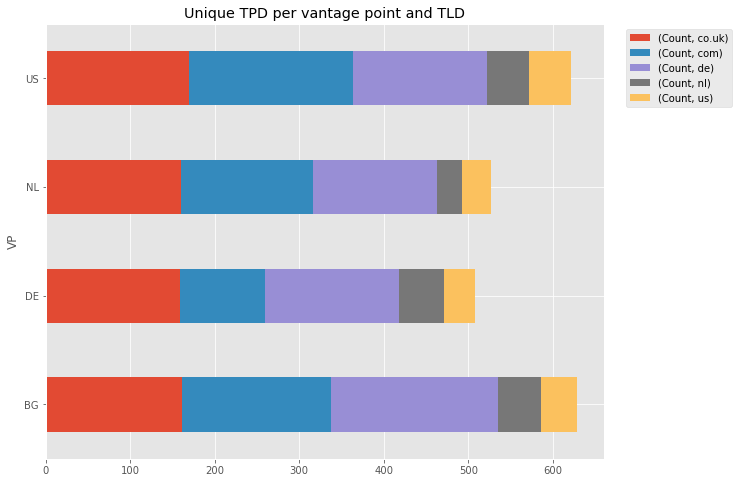

In [15]:
#count unique TPD in each VP per TLD
u_tpd_VP_TLD=tpd_unique.groupby('VP')['TLD'].value_counts().unstack().stack(dropna=False).reset_index(name="Count").set_index(['VP', 'TLD'])
print(u_tpd_VP_TLD)
print(u_tpd_VP_TLD.describe())

#when interpreting this graph keep in mind that .com crawled websites were 61
t1=u_tpd_VP_TLD.unstack().plot.barh(stacked=True,figsize=(10, 8),title='Unique TPD per vantage point and TLD', legend=True)
horiz_offset = 1.03
vert_offset = 1.0
t1.legend(bbox_to_anchor=(horiz_offset, vert_offset))
#plt.savefig('fig',bbox_inches='tight')

In [16]:
#Descriptive stats unique tpd count
tpd_unique.groupby(['VP']).describe()

is_session                                    timediff  \
        count mean  std  min  25%  50%  75%  max    count   
VP                                                          
BG      629.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      629   
DE      508.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      508   
NL      527.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      527   
US      622.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      622   

                                                                           \
                        mean                        std               min   
VP                                                                          
BG  746 days 20:24:20.125596  4531 days 15:03:45.593977  30 days 00:00:00   
DE  845 days 17:02:15.570866  5061 days 10:45:20.919891  30 days 00:00:00   
NL  852 days 02:46:02.108159  4965 days 04:16:08.491814  30 days 00:00:00   
US  753 days 07:04:50.615755  4566 days 00:35:32.066170  30 days 00:00:00   

                                                             \
                  25%                50%                75%   
VP                                                            
BG  180 days 00:00:00  365 days 00:00:00  390 days 00:00:00   
DE  180 days 00:00:00  365 days 00:00:00  390 days 00:00:00   
NL  180 days 00:00:00  365 days 00:00:00  390 days 00:00:00   
US  180 days 00:00:00  365 days 00:00:00  390 days 00:00:00   

                         
                    max  
VP                       
BG  99999 days 00:00:00  
DE  99999 days 00:00:00  
NL  99999 days 00:00:00  
US  99999 days 00:00:00

### US Unique TPD

In [17]:
#Unique TPD- VP US
tpd_US_unique=tpd_unique[tpd_unique.VP=='US'].sort_values(by='site_url')
df_US_unique= pd.DataFrame(data=tpd_US_unique)
#df_US_unique.head()
df_US_unique.shape

(622, 12)

                    host  VP
site_url                    
microsoft.com         37  US
businessinsider.de    26  US
mathtag.com           26  US
web.de                26  US
dailymail.co.uk       25  US


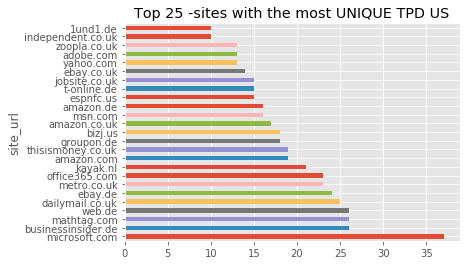

In [18]:
#Websites with more unique tpd -VP: US
u_tpd_US_unique=pd.DataFrame(df_US_unique.groupby('site_url')['host'].count().sort_values(ascending=False))
#print(u_tpd_US_unique.head())
df_US_unique.groupby('site_url')['host'].count().sort_values(ascending=False)[:25].plot(kind='barh',title='Top 25 -sites with the most UNIQUE TPD US')
u_tpd_US_unique['VP']='US'
print(u_tpd_US_unique.head())

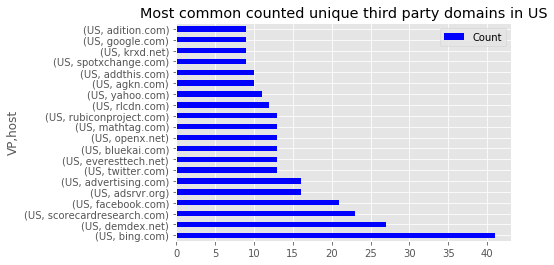

In [19]:
#most popular unique third party domains US
tpd_US_unique_2=df_US_unique.groupby('VP')['host'].value_counts().unstack().stack(dropna=True).reset_index(name="Count").set_index(['VP', 'host']).sort_values(by='Count',ascending=False)
tpd_US_unique_2.iloc[0:20,]
plt.figure(figsize=(8,6))
(tpd_US_unique_2.iloc[0:20,]).plot(kind='barh',title='Most common counted unique third party domains in US', color='blue')

### NL Unique TPD

In [20]:
#Unique TPD- VP NL
tpd_NL_unique=tpd_unique[tpd_unique.VP=='NL'].sort_values(by='site_url')
df_NL_unique= pd.DataFrame(data=tpd_NL_unique)
#df_NL_unique.head()
df_NL_unique.shape

(527, 12)

                 host  VP
site_url                 
1und1.de           38  NL
dailymail.co.uk    38  NL
yahoo.com          35  NL
t-online.de        33  NL
mathtag.com        27  NL


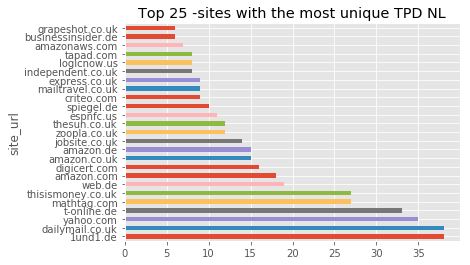

In [21]:
#Websites with more unique TPD -VP: NL
u_tpd_NL_unique=pd.DataFrame(df_NL_unique.groupby('site_url')['host'].count().sort_values(ascending=False))
#print(u_tpd_NL_unique.head())
df_NL_unique.groupby('site_url')['host'].count().sort_values(ascending=False)[:25].plot(kind='barh',title='Top 25 -sites with the most unique TPD NL')
u_tpd_NL_unique['VP']='NL'
print(u_tpd_NL_unique.head())

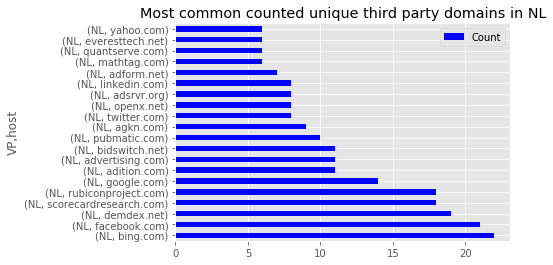

In [22]:
#most popular unique third party domains NL
tpd_NL_unique_2=df_NL_unique.groupby('VP')['host'].value_counts().unstack().stack(dropna=True).reset_index(name="Count").set_index(['VP', 'host']).sort_values(by='Count',ascending=False)
tpd_NL_unique_2.iloc[0:20,]
plt.figure(figsize=(8,6))
(tpd_NL_unique_2.iloc[0:20,]).plot(kind='barh',title='Most common counted unique third party domains in NL', color='blue')

### DE Unique TPD


In [23]:
#Unique TPD- VP DE
tpd_DE_unique=tpd_unique[tpd_unique.VP=='DE'].sort_values(by='site_url')
df_DE_unique= pd.DataFrame(data=tpd_DE_unique)
#df_DE_unique.head()
df_DE_unique.shape

(508, 12)

                    host  VP
site_url                    
businessinsider.de    28  DE
dailymail.co.uk       23  DE
thisismoney.co.uk     23  DE
t-online.de           22  DE
intelliad.de          20  DE


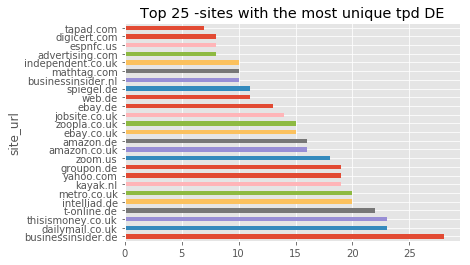

In [24]:
#Websites with more unique tpd -VP: DE
u_tpd_DE_unique=pd.DataFrame(df_DE_unique.groupby('site_url')['host'].count().sort_values(ascending=False))
#print(u_tpd_DE_unique.head())
df_DE_unique.groupby('site_url')['host'].count().sort_values(ascending=False)[:25].plot(kind='barh',title='Top 25 -sites with the most unique tpd DE')
u_tpd_DE_unique['VP']='DE'
print(u_tpd_DE_unique.head())

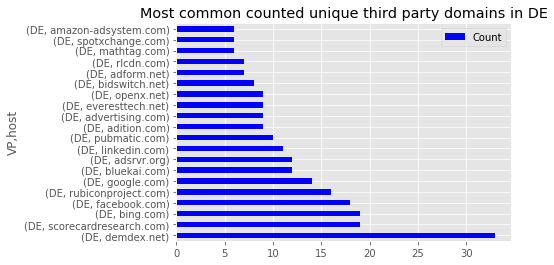

In [25]:
#most popular unique third party domains DE
tpd_DE_unique_2=df_DE_unique.groupby('VP')['host'].value_counts().unstack().stack(dropna=True).reset_index(name="Count").set_index(['VP', 'host']).sort_values(by='Count',ascending=False)
tpd_DE_unique_2.iloc[0:20,]
plt.figure(figsize=(8,6))
(tpd_DE_unique_2.iloc[0:20,]).plot(kind='barh',title='Most common counted unique third party domains in DE', color='blue')

### BG Unique cookies

In [26]:
#Unique tpd- VP BG
tpd_BG_unique=tpd_unique[tpd_unique.VP=='BG'].sort_values(by='site_url')
df_BG_unique= pd.DataFrame(data=tpd_BG_unique)
#df_BG_unique.head()
df_BG_unique.shape

(629, 12)

                    host  VP
site_url                    
yahoo.com             43  BG
1und1.de              39  BG
ebay.de               27  BG
businessinsider.de    25  BG
mathtag.com           25  BG


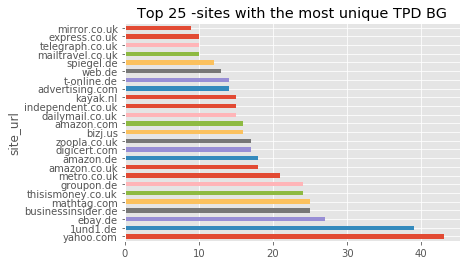

In [27]:
#Websites with more unique tpd -VP: BG
u_tpd_BG_unique=pd.DataFrame(df_BG_unique.groupby('site_url')['host'].count().sort_values(ascending=False))
#print(u_tpd_BG_unique.head())
df_BG_unique.groupby('site_url')['host'].count().sort_values(ascending=False)[:25].plot(kind='barh',title='Top 25 -sites with the most unique TPD BG')
u_tpd_BG_unique['VP']='BG'
print(u_tpd_BG_unique.head())

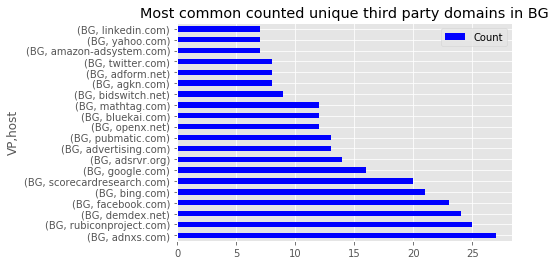

In [28]:
#most popular unique third party domains DE
tpd_BG_unique_2=df_BG_unique.groupby('VP')['host'].value_counts().unstack().stack(dropna=True).reset_index(name="Count").set_index(['VP', 'host']).sort_values(by='Count',ascending=False)
tpd_BG_unique_2.iloc[0:20,]
plt.figure(figsize=(8,6))
(tpd_BG_unique_2.iloc[0:20,]).plot(kind='barh',title='Most common counted unique third party domains in BG', color='blue')

### DV UNIQUE TPD COUNT

In [29]:
#UNIQUE tpd cookies DV
tpddv_unique= pd.concat([u_tpd_NL_unique,u_tpd_US_unique,u_tpd_DE_unique,u_tpd_BG_unique]).reset_index()
tpddv_unique=tpddv_unique.sort_values(by='site_url')
#tpddv_unique=tpddv_unique.sort_values(by='name',ascending=False)
tpddv_unique.head(100)
#tpddv_unique.shape 

#check=tpddv_count[(tpddv_count.site_url=='microsoft.com')]
#check

,site_url,host,VP
0,1und1.de,38,NL
106,1und1.de,10,US
251,1und1.de,39,BG
204,1und1.de,3,DE
220,7gra.us,2,DE
46,7gra.us,2,NL
302,7gra.us,2,BG
130,7gra.us,2,US
57,ad.nl,1,NL
230,ad.nl,1,DE


BG         Axes(0.1,0.559091;0.363636x0.340909)
DE    Axes(0.536364,0.559091;0.363636x0.340909)
NL             Axes(0.1,0.15;0.363636x0.340909)
US        Axes(0.536364,0.15;0.363636x0.340909)
dtype: object

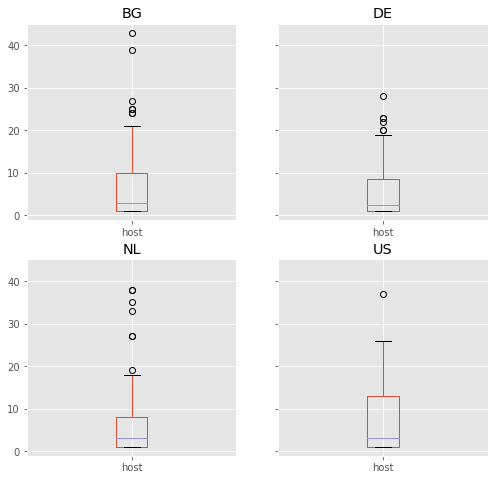

In [30]:
#Boxplot per VP - OUTLIERS are real observations
tpddv_unique.groupby('VP').boxplot(figsize=[8,8])

In [31]:
#Descriptive stats Counted cookies - Dependend variable
#There is overdispersion the sdv/mean >1
tpddv_unique.groupby('VP').describe()

host                                               
   count      mean       std  min  25%  50%   75%   max
VP                                                     
BG  91.0  6.912088  8.659803  1.0  1.0  3.0  10.0  43.0
DE  84.0  6.047619  6.908882  1.0  1.0  2.5   8.5  28.0
NL  82.0  6.426829  8.791172  1.0  1.0  3.0   8.0  38.0
US  84.0  7.404762  8.406995  1.0  1.0  3.0  13.0  37.0

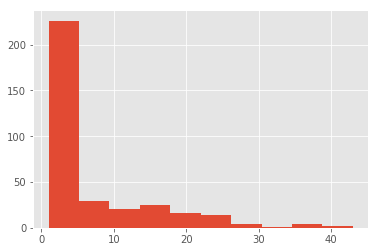

In [32]:
#Histogram of counted cookies - shape of the distribution is skew and non normal - Negative Binomial
#It cannot be poisson because the mean is different form the sd
tpddv_unique.host.hist()

In [33]:
x=tpddv_unique.host.kurtosis()
print('Kurtosis:', x)
y=tpddv_unique.host.skew()
print('Skweness:', y)

Kurtosis: 3.208580150417816
Skweness: 1.8351061309161842
